In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
import xarray as xr
import xbudget
import xwmb
from CM4Xutils import *

In [3]:
local_path_to_budgets_zarr = "../../../codedev/CM4Xutils/data/coarsened/CM4Xp25_budgets_sigma2_1850-1854.zarr"

In [4]:
ds = xr.open_zarr(local_path_to_budgets_zarr)
grid = ds_to_grid(ds.fillna(0.))

Inferring Z grid coordinate: density `sigma2`


In [9]:
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)

    budgets_dict = xbudget.load_preset_budget(model="MOM6_3Donly")
    xbudget.collect_budgets(grid, budgets_dict)
    
    wmb = xwmb.WaterMassBudget(
        grid,
        budgets_dict
    )
    wmb.mass_budget("sigma2", greater_than=True, default_bins=True, integrate=True, along_section=False)
    wmt = wmb.wmt

In [10]:
%time wmt_mean = (wmt.sel(exp="control").mean("time")/1035*1e-6).compute()

CPU times: user 11min 8s, sys: 4min 17s, total: 15min 26s
Wall time: 1min 53s


In [11]:
def stairs(wmt, var, units="kg", **kwargs):
    da = wmt[var]
    coord = wmt[[c for c in wmt.coords if "l_target" in c][0]]
    coord_bounds = wmt[[c for c in wmt.coords if "i_target" in c][0]]
    l = plt.stairs(da, coord_bounds, **kwargs, orientation="horizontal")
    plt.xlabel(f"mean transformation rate [{units}]")
    return l

(-50.0, 50.0)

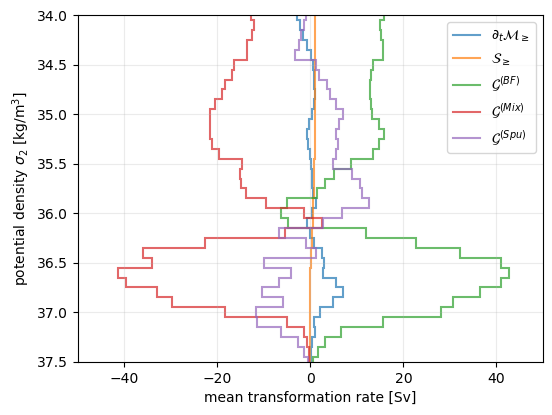

In [13]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6,4.5))

kwargs = {"units":"Sv", "alpha":0.7, "lw":1.5}

stairs(-wmt_mean, 'mass_tendency',             label=r"$\partial_{t} \mathcal{M}_{\geq}$",**kwargs)
stairs( wmt_mean, 'mass_source',               label=r"$\mathcal{S}_{\geq}$",            **kwargs)
stairs( wmt_mean, 'boundary_fluxes',           label=r"$\mathcal{G}^{(BF)}$",      **kwargs)
stairs( wmt_mean, 'diffusion',                 label=r"$\mathcal{G}^{(Mix)}$",     **kwargs)
stairs( wmt_mean, 'spurious_numerical_mixing', label=r"$\mathcal{G}^{(Spu)}$", **kwargs)

plt.legend(loc="upper right")
plt.grid(True, alpha=0.25)
plt.ylabel(r"potential density $\sigma_{2}$ [kg/m$^{3}$]");
plt.ylim(37.5, 34.);
plt.xlim(-50, 50)